# Predicting whether movie reviews contain spoilers

### Manuel Albrizzio, Adnan Cihan Cakar, Jared Grove, Johnny Joyce


# Resources used:

* Scikit-learn documentation
* SciPy documentation
* NLTK documentation
* Pandas documentation

# Importing Kaggle API and the data set

In [ ]:
import pandas as pd
import nltk
import kaggle
import matplotlib.pyplot as plt
import seaborn as snsimport string
from nltk.tokenize import  word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np

In [ ]:
# Upload the kaggle api key "kaggle.json" I have it saved in my downloads folder
# You would need your own Kaggle API to do this part. If not you will need use the .pkl file 
# and start just above encoding the data at: df_total = pd.read_pickle("Processed_and_encoded_50k.pkl")
from google.colab import files


uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
#Import the dataset from kaggle
! kaggle datasets download rmisra/imdb-spoiler-dataset

imdb-spoiler-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Unzip the dataset to be useable
!unzip -q imdb-spoiler-dataset.zip

# Pre-processing the data

This block defines functions to


*   Change movie durations from strings to integers
*   Change strings of text (e.g. bodies of reviews) into lists of "stemmed" words





In [ ]:
def to_mins(duration):
    """ Takes movie duration as str and returns duration as int (total minutes)"""
    if "h " in duration and "min" in duration:
        hrs, mins = duration.split("h ")
        return int(hrs)*60 + int(mins[:-3])
        
    elif "h" in duration:
        hrs = duration.split("h")[0]
        return int(hrs)*60
    else:
        mins = duration[:-3]
        return int(mins)




def review_process(review_text, stemming = True):
    '''this funtion requires the word_tokenize from nltk.tokenize to be imported
    this funtion requires the PorterStemmer from nltk.stem to be imported if stemming is True
    this function takes a review text body and applies the following process:
    1) lowercase the review
    2) split the review to a
    3) removes stopwords
    4) stem the list if stemming is true
    returns a list of resulting words'''

    review_list = word_tokenize(review_text.lower())
    review_list = [word for word in review_list
                    if (any([l in non_puckt for l in word ])) and (word not in sw)]
    review_list = [word if (not word == "n't") else 'not' for word in review_list ]
    review_list = [ps.stem(word) for word in review_list ]
    return review_list



nltk.download('punkt')
nltk.download('stopwords')
non_puckt = string.ascii_lowercase+string.digits


global ps
ps = PorterStemmer()
global sw
sw = stopwords.words('english')
sw += ["'s"]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This block pre-processes the data by applying the relevant functions. The number of entries is also reduced from around 570 000 to 50 000 to allow feasible runtimes.

In [ ]:
# Read in the seperate datasets and rename the review column for each to be unique
df_reviews = pd.read_json('IMDB_reviews.json', lines = True)
df_details = pd.read_json('IMDB_movie_details.json', lines = True)

df_reviews = df_reviews.sample(50000, random_state=38) # Reduce size to 50 000
df_reviews = df_reviews.rename(columns = {'rating':'review_rating'})
df_reviews["review_summary"] = df_reviews["review_summary"].map(review_process) # Pre-process "review_summary"
df_reviews["review_text"] = df_reviews["review_text"].map(review_process) # Pre-process "review_text"

df_details  = df_details.rename(columns = {'rating':'movie_rating'}) 
df_details['numerical_Duration'] = df_details["duration"].apply(to_mins)
df_details["plot_summary"] = df_details["plot_summary"].map(review_process) # Pre-process "plot_summary"
df_details["plot_synopsis"] = df_details["plot_synopsis"].map(review_process) # Pre-process "plot_details"


# Merge the dataframes together on movie_id
df_total = pd.merge(df_reviews, df_details, on = 'movie_id')

#Convert the dates to datetime format
df_total['num_review_date'] =  pd.to_datetime(df_total['review_date'])
df_total['num_release_date'] =  pd.to_datetime(df_total['release_date'])
#Create days from release to review
df_total['days_from_release_to_review'] = (df_total['num_review_date'] - df_total['num_release_date']).dt.days

# Exporting the results to shareable file format

`pickle` was used to share the processed data between computers. We attempted to share with one-hot encoding, but these used too much RAM. Instead, the encoding was performed separately on each device.

In [ ]:
#Make a dictionary with every word in the tokenized plot_summary and tokenized plot_review
df_total.to_pickle("./Processed_50k.pkl")

0        [evacu, alli, soldier, british, empir, franc, ...
1        [evacu, alli, soldier, british, empir, franc, ...
2        [evacu, alli, soldier, british, empir, franc, ...
3        [evacu, alli, soldier, british, empir, franc, ...
4        [evacu, alli, soldier, british, empir, franc, ...
                               ...                        
49994    [black, beauti, beauti, black, stallion, 1870,...
49995    [stori, begin, spanki, presid, he-man, woman, ...
49996    [summer, parker, famili, usual, number, event,...
49997    [sylvia, work, increasingli, take, away, three...
49998    [jose, lui, execut, parent, underwear, factori...
Name: plot_summary, Length: 49999, dtype: object

In [ ]:
df_total = pd.read_pickle("Processed_and_encoded_50k.pkl")

# Encoding the data

`scikit-learn`'s MultiLabelBinarizer was used to encode the lists of words into one-hot vectors, which were then summed for each review.

This process used a significant amount of RAM, so only 5000 samples were used.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import HashingVectorizer

#df_total = df_total.sample(5000, random_state=38)
# Use MultiLabelBinarizer to convert [a,b,c] -> three binary columns for the presence of a,b,c
mlb = MultiLabelBinarizer()
df1 = pd.DataFrame(mlb.fit_transform(df_total['review_summary']),columns=mlb.classes_, index=df_total.index)
df2 = pd.DataFrame(mlb.fit_transform(df_total['plot_summary']),columns=mlb.classes_, index=df_total.index)
df3 = pd.DataFrame(mlb.fit_transform(df_total['review_text']),columns=mlb.classes_, index=df_total.index)
df4 = pd.DataFrame(mlb.fit_transform(df_total['plot_synopsis']),columns=mlb.classes_, index=df_total.index)
 
# Convert the MLB output into a single vector for each row
review_summary_Vect = []
plot_summary_Vect = []
review_text_Vect = []
plot_synopsis_Vect = []
for i,r in df1.iterrows():
 review_summary_Vect.append(r.values)
for i,r in df2.iterrows():
 plot_summary_Vect.append(r.values)
for i,r in df1.iterrows():
 review_text_Vect.append(r.values)
for i,r in df2.iterrows():
 plot_synopsis_Vect.append(r.values)
 
# Combine into the df_total
df_total['review_summary_Vect'] = review_summary_Vect
df_total['plot_summary_Vect'] = plot_summary_Vect
df_total['review_text_Vect'] = review_text_Vect
df_total['plot_synopsis_Vect'] = plot_synopsis_Vect

In [ ]:
Tdf_total.to_pickle("./Processed_and_encoded_5k.pkl")

# Preparing and training logistic regression model


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import jaccard
 
df_total['plot_summary'] = df_total['plot_summary'].map(np.array)
df_total['review_summary'] = df_total['review_summary'].map(np.array)
 
df_total['difference'] = np.zeros(len(df_total))
for i in range(len(df_total)):
  df_total.at[i, 'difference'] = jaccard(df_total.at[i, 'plot_summary'] - df_total.at[i, 'review_summary'])
 
df_total['difference'] = df_total['difference']
X_train, X_test, y_train, y_test = train_test_split(df_total[['difference']], df_total['is_spoiler'],
                                                    test_size = 0.2)
st_sc = StandardScaler()
X_train = st_sc.fit_transform(X_train)
X_test = st_sc.transform(X_test)
 
log_reg = LogisticRegression().fit(X_train, y_train)
f1_score(y_test, log_reg.predict(X_test))

# Preparing and training KNN model

In [ ]:
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
 
# Read in the preprocessed file
df = pd.read_pickle('/content/gdrive/MyDrive/Processed_50k.pkl')
 
X1 = df_reduced[['review_summary_Vect', 'plot_summary_Vect']].to_numpy()   #Appends encoded review and plot summary vectors
X2 = []
for i in range(len(X1)):
  row = X1[i][0]
  for j in range(1,len(X1[i])):
    np.append(row, X1[i][j])
  X2.append(row)     
 
y = df_reduced['is_spoiler'].to_numpy()
 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.20, random_state = 0)  #train-test-split on dataset with test size of 0.2

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)  #feature scaling to the variables
X_test = sc.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2) #create and train KNN Model (using Euclidean metric)
classifier.fit(X_train, y_train) 

ypredknn=classifier.predict(X_test) #Predict output on test values

from sklearn.metrics import confusion_matrix,accuracy_score #Compare the values predicted to the true values
cm = confusion_matrix(y_test, ypredknn)
ac = accuracy_score(y_test,ypredknn)

f1_score(y_test,ypredknn,average=None) #Compute F1-score on test and predicted dependent values.


# Preparing and training other prediction models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Read in the preprocessed file
df = pd.read_pickle('/content/gdrive/MyDrive/Processed_50k.pkl')

from sklearn.preprocessing import MultiLabelBinarizer
# Use MultiLabelBinarizer to convert [a,b,c] -> three binary columns for the presence of a,b,c
mlb = MultiLabelBinarizer()
uprange = 10000
df1 = pd.DataFrame(mlb.fit_transform(df['review_summary'][:uprange]),columns=mlb.classes_, index=df[:uprange].index)
df2 = pd.DataFrame(mlb.fit_transform(df['plot_summary'][:uprange]),columns=mlb.classes_, index=df[:uprange].index)
print(df1.shape, df2.shape)

# Convert the MLB output into a single vector for each row
review_summary_Vect = []
plot_summary_Vect = []
for i,r in df1.iterrows():
  review_summary_Vect.append(r.values)
for i,r in df2.iterrows():
  plot_summary_Vect.append(r.values)

df_reduced = df[:uprange]

# Combine into the smaller df_total
df_reduced['review_summary_Vect'] = review_summary_Vect
df_reduced['plot_summary_Vect'] = plot_summary_Vect


# Make 0-1 response rather than true/false. Make easier to use as input
y = df_reduced['is_spoiler'].to_numpy()
y_int = []
for i in y:
  if i:
    y_int.append(1)
  else:
    y_int.append(0)
X1 = df_reduced[['review_summary_Vect', 'plot_summary_Vect']].to_numpy()
X2 = []
for i in range(len(X1)):
  row = X1[i][0]
  for j in range(1,len(X1[i])):
    np.append(row, X1[i][j])
  X2.append(row)

# Split into test/train
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.33, random_state=42)
X_train_cont, X_test_cont, y_train_cont, y_test_cont = train_test_split(X2, y_int, test_size=0.33, random_state=42)

# Perform a PCA decomposition
pca = PCA(n_components=800)
X_train_pca = pca.fit_transform(X_train)
print(sum(pca.explained_variance_ratio_))
X_test_pca = pca.transform(X_test)

# Make 0-1 response rather than true/false. Make easier to use as input. Add more variables for models
y_exp = df_reduced['is_spoiler'].to_numpy()
y_int_exp = []
for i in y:
  if i:
    y_int_exp.append(1)
  else:
    y_int_exp.append(0)
X1_exp = df_reduced[['review_summary_Vect', 'plot_summary_Vect', 'numerical_Duration', 'days_from_release_to_review']].to_numpy()
X2_exp = []
for i in range(len(X1)):
  row = X1_exp[i][0]
  for j in range(1,len(X1_exp[i])):
    np.append(row, X1_exp[i][j])
  X2_exp.append(row)

#Test train split
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X2_exp, y_exp, test_size=0.33, random_state=42)
X_train_cont_exp, X_test_cont_exp, y_train_cont_exp, y_test_cont_exp = train_test_split(X2_exp, y_int_exp, test_size=0.33, random_state=

In [ ]:
# Train and Evaluate Models:

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score

#Models on smaller set of inputs
#Logistic Regression
logReg = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred_logReg = logReg.predict(X_test)
print('Logistic Regression Accuracy: %f', logReg.score(X_test, y_test))
print('F1-Score: ', f1_score(y_test, y_pred_logReg, average=None))

#Linear Regression
linReg = LinearRegression().fit(X_train_cont, y_train_cont)
y_pred_linReg = linReg.predict(X_test_cont)
print('Linear Regression Accuracy: ', linReg.score(X_test_cont, y_test_cont))

#LASSO Regression
lassoReg = linear_model.Lasso(alpha=0.01)
lassoReg.fit(X_train_cont, y_train_cont)
y_pred_lassoReg = lassoReg.predict(X_test_cont)
print('LASSO Regression Accuracy: ', lassoReg.score(X_test_cont, y_test_cont))

#Random Forest
RFClass = RandomForestClassifier(max_depth=2, random_state=0)
RFClass.fit(X_train, y_train)
y_pred_RF = RFClass.predict(X_test)
print('Random Forrest Classifier Accuracy: ', RFClass.score(X_test, y_test))
print('F1 Score: ', f1_score(y_test, y_pred_RF))

#KNN Classifier
KNNs = KNeighborsClassifier(n_neighbors=50)
KNNs.fit(X_train, y_train)
KNNs_guess = np.round(KNNs.predict(X_test))
accuracy = 1-(np.sum(abs(KNNs_guess-y_test))/len(KNNs_guess))
print("KNN Classifier (k=50) accuracy: ", accuracy)
print('F1Score: ', f1_score(y_test, KNNs_guess))

#SVM Classifier
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(X_train_cont, y_train_cont)
y_pred_svm = svm.predict(X_test)
print('SVM Accuracy: ', svm.score(X_test, y_test))

#Models on larger set of inputs

#Logistic Regression
logReg_exp = LogisticRegression(random_state=0).fit(X_train_exp, y_train_exp)
y_pred_logReg_exp = logReg_exp.predict(X_test_exp)
print('Logistic Regression Accuracy: ', logReg_exp.score(X_test_exp, y_test_exp))
print('F1-Score: ', f1_score(y_test_exp, y_pred_logReg_exp, average=None))


#Linear Regression
linReg_exp = LinearRegression().fit(X_train_cont_exp, y_train_cont_exp)
y_pred_linReg_exp = linReg_exp.predict(X_test_cont_exp)
correct = 0.0
total = 0.0
for i in range(len(y_pred_linReg_exp)):
  if y_pred_linReg_exp[i] < 0.5:
    y_pred_linReg_exp[i] = 0
  else:
    y_pred_linReg_exp[i] = 1
  if y_pred_linReg_exp[i] == y_test_cont_exp[i]:
    correct += 1
  total += 1
print('Linear Regression Manual Accuracy: ', correct/total)

#Lasso Regression
lassoReg_exp = linear_model.Lasso(alpha=1)
lassoReg_exp.fit(X_train_cont_exp, y_train_cont_exp)
y_pred_lassoReg_exp = lassoReg.predict(X_test_cont_exp)
correct = 0.0
total = 0.0
for i in range(len(y_pred_lassoReg_exp)):
  if y_pred_lassoReg_exp[i] < 0.5:
    y_pred_lassoReg_exp[i] = 0
  else:
    y_pred_lassoReg_exp[i] = 1
  if y_pred_lassoReg_exp[i] == y_test_cont_exp[i]:
    correct += 1
  total += 1
print('LASSO Regression Manual Accuracy: ', correct/total)

#Random Forrest Classifier
RFClass_exp = RandomForestClassifier(max_depth=2, random_state=0)
RFClass_exp.fit(X_train_exp, y_train_exp)
y_pred_RF_exp = RFClass_exp.predict(X_test_exp)
print('Random Forrest Classifier Accuracy: ', RFClass_exp.score(X_test_exp, y_test_exp))
print('F1 Score: ', f1_score(y_test_exp, y_pred_RF_exp))

#KNN Classifier
KNNs_exp = KNeighborsClassifier(n_neighbors=50)
KNNs_exp.fit(X_train_exp, y_train_exp)
KNNs_guess_exp = np.round(KNNs_exp.predict(X_test_exp))
accuracy_exp = 1-(np.sum(abs(KNNs_guess_exp-y_test_exp))/len(KNNs_guess_exp))
print("KNN Classifier (k=50) accuracy: ", accuracy_exp)
print('F1Score: ', f1_score(y_test_exp, KNNs_guess_exp))

#SVM - rbf kernel
svm_exp = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel = 'rbf'))
svm_exp.fit(X_train_exp, y_train_exp)
y_pred_svm_exp = svm_exp.predict(X_test_exp)
print('SVM Accuracy: ', svm_exp.score(X_test_exp, y_test_exp))
print('F1 Score: ', f1_score(y_test_exp, y_pred_svm_exp))

#SVM - default kernel
svm_exp = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm_exp.fit(X_train_exp, y_train_exp)
y_pred_svm_exp = svm_exp.predict(X_test_exp)
print('SVM Accuracy: ', svm_exp.score(X_test_exp, y_test_exp))
print('F1 Score: ', f1_score(y_test_exp, y_pred_svm_exp))

#Logistic Regression with PCA
logReg_pca = LogisticRegression(random_state=0).fit(X_train_pca, y_train)
y_pred_logReg_pca = logReg_pca.predict(X_test_pca)
print('Logistic Regression Accuracy: ', logReg_pca.score(X_test_pca, y_test))
print('F1-Score: ', f1_score(y_test, y_pred_logReg_pca, average=None))

# Plotting various attributes of the data

In [ ]:
# movie_rating vs duration
sns.scatterplot(data=df_details, x="movie_rating", y="numerical_Duration")
#Split duration into 5 minute increments
# Duration vs rating
sns.scatterplot(data=df_details, x="binned_Duration", y="movie_rating")
#Days from Release vs Rating
sns.scatterplot(data=df_total, x="days_from_release_to_review", y="movie_rating")

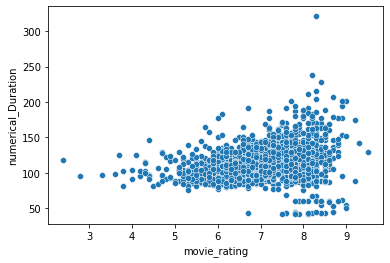

In [ ]:
#Split duration into 5 minute increments
# movie_rating vs duration 
sns.scatterplot(data=df_details, x="movie_rating", y="numerical_Duration")

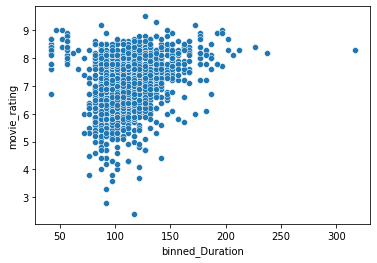

In [ ]:
#Split duration into 5 minute increments
sns.scatterplot(data=df_details, x="binned_Duration", y="movie_rating")

In [ ]:
df_total['review_date']

0         10 February 2006
1         6 September 2000
2            3 August 2001
3         1 September 2002
4              20 May 2004
                ...       
573901       8 August 1999
573902        31 July 1999
573903        20 July 1999
573904        11 June 1999
573905          3 May 1999
Name: review_date, Length: 573906, dtype: object

In [ ]:
#Convert the dates to datetime format
df_total['num_review_date'] =  pd.to_datetime(df_total['review_date'])
df_total['num_release_date'] =  pd.to_datetime(df_total['release_date'])
#Create days from release to review
df_total['days_from_release_to_review'] = (df_total['num_review_date'] - df_total['num_release_date']).dt.days

In [ ]:
#Create days from release to review
df_total['days_from_release_to_review'] = (df_total['num_review_date'] - df_total['num_release_date']).dt.days

In [ ]:
df_total['days_from_release_to_review']

0         4137
1         2154
2         2485
3         2879
4         3506
          ... 
573901     121
573902     113
573903     102
573904      63
573905      24
Name: days_from_release_to_review, Length: 573906, dtype: int64

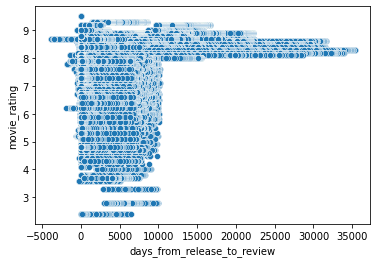

In [ ]:
sns.scatterplot(data=df_total, x="days_from_release_to_review", y="movie_rating")

In [ ]:
import string
from nltk.tokenize import  word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
non_puckt = string.ascii_lowercase+string.digits

def review_process(review_text, stemming = True):
  # this funtion requires the word_tokenize from nltk.tokenize to be imported
  # this funtion requires the PorterStemmer from nltk.stem to be imported if stemming is True
  # this function takes a review text body and applies the following process:
  # 1) lowercase the review
  # 2) split the review to a
  # 3) removes stopwords
  # 4) stem the list if stemming is true
  # returns a list of resulting words
 
  #import stopwords
  sw = stopwords.words('english')
  sw += ["'s"]
  review_list = word_tokenize(review_text.lower())
  review_list = [word for word in review_list
                 if (any([l in non_puckt for l in word ])) and (word not in sw)]
  review_list = [word if (not word == "n't") else 'not' for word in review_list ]
  if stemming == True:
    ps = PorterStemmer()
    review_list = [ps.stem(word) for word in review_list ]
  return review_list


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_total['review_summary'] = df_total['review_summary'].map(review_process)

0       [classic, piec, unforgett, film-mak]
1             [simpli, amaz, best, film, 90]
2            [best, stori, ever, told, film]
3                    [busi, die, busi, live]
4        [great, stori, wondrous, told, act]
                        ...                 
9995           [thrill, storylin, left, aww]
9996              [best, action, movi, time]
9997                                  [seri]
9998                                [review]
9999                           [hail, joker]
Name: review_summary, Length: 10000, dtype: object